# Código Trabalho 2 (Regressão)

## Definindo os DataFrames de treinamento e de teste

In [1]:
import pandas as pd

df_train = pd.read_csv('Dataset/conjunto_de_treinamento.csv')
df_test = pd.read_csv('Dataset/conjunto_de_teste.csv')

df_train.shape

(4683, 21)

## Pré-processamento dos dados

### Funções usadas para "tratar" os dados: 
- Atribuir valores numéricos às variáveis nominais;
- Remover variáveis que não trazem boas contribuições para o resultado final (olhar a sessão de "análise de dados" ao final do código)
- Preenche espaços em branco (`null`) nas colunas que precisam

In [2]:
def DataProcessing1(df):
    # Exclui colunas que não serão utilizadas
    df.drop(columns=['Id', 'diferenciais', 'tipo_vendedor', 'area_extra', 'estacionamento'], inplace=True)
    df.drop(columns=['quartos', 'piscina', 's_ginastica'], inplace=True)

    # Transforma coluna 'tipo' em numérica
    df['tipo'] = df['tipo'].map({'Apartamento': 1, 'Casa': 2})
    df.fillna(0.5, inplace=True)

    return df

Na função `DataProcessing1`, as variáveis `'tipo_vendedor'`, `'area_extra'`, `'estacionamento'` foram removidas por ter uma correlação muito baixa com as outras variáveis. Os gráficos a seguir mostram a correlação entre as variáveis para cada uma destas:

![vendedor](C:\Users\carol\OneDrive\Documentos\GitHub\Introduction-to-Machine-Learning-EEL891\Trabalho 2 - Regressão\graficos correlação (variáveis excuídas)\tipo_vendedor.png)

![areaextra](C:\Users\carol\OneDrive\Documentos\GitHub\Introduction-to-Machine-Learning-EEL891\Trabalho 2 - Regressão\graficos correlação (variáveis excuídas)\area_extra.png)

![estacionamento](C:\Users\carol\OneDrive\Documentos\GitHub\Introduction-to-Machine-Learning-EEL891\Trabalho 2 - Regressão\graficos correlação (variáveis excuídas)\estacionamento.png)


In [3]:
def DataProcessing2(df):
    # Calcula a média dos valores dos imóveis por bairro
    mean_encoded = df.groupby('bairro')['preco'].mean()
    
    # Cria um dicionário com os bairros originais e suas respectivas versões codificadas (valores médios dos imóveis)
    bairros_config = mean_encoded.to_dict()
    
    # Mapeia os valores médios dos imóveis por bairro para todos os bairros
    df['bairro'] = df['bairro'].map(mean_encoded)

    return df, bairros_config


In [4]:
def CodificarBairroTeste(df, bairros_config):
    # Codifica a coluna 'bairro' do conjunto de teste de acordo com o dicionário criado por DataProcessing2(df_train)
    df['bairro'] = df['bairro'].map(bairros_config)
    df_test['bairro'].fillna(df_test['bairro'].mean(), inplace=True)

    return df


In [5]:
# Passa os DataFrames pelas funções de pré-processamento
df_train = DataProcessing1(df_train)
df_test = DataProcessing1(df_test)

df_train, bairros_enc = DataProcessing2(df_train)
df_test = CodificarBairroTeste(df_test, bairros_enc)

### Checando o pré-processamento
Verifica se todas as colunas dos DataFrames de treinamento e teste estão completamente preenchidas, e se o formato dos dados é numérico.

In [6]:
# Conta o número de valores NaN em cada coluna
contagem_nan = df_test.isnull().sum(), df_train.isnull().sum()
# Exibe a contagem de valores NaN
print(contagem_nan[0], '\n\n', contagem_nan[1])


tipo             0
bairro           0
suites           0
vagas            0
area_util        0
churrasqueira    0
playground       0
quadra           0
s_festas         0
s_jogos          0
sauna            0
vista_mar        0
dtype: int64 

 tipo             0
bairro           0
suites           0
vagas            0
area_util        0
churrasqueira    0
playground       0
quadra           0
s_festas         0
s_jogos          0
sauna            0
vista_mar        0
preco            0
dtype: int64


#### Output desejado:

df_test
- tipo             0
- bairro           0
- suites           0
- vagas            0
- area_util        0
- churrasqueira    0
- playground       0
- quadra           0
- s_festas         0
- s_jogos          0
- sauna            0
- vista_mar        0

df_train
- tipo             0
- bairro           0
- suites           0
- vagas            0
- area_util        0
- churrasqueira    0
- playground       0
- quadra           0
- s_festas         0
- s_jogos          0
- sauna            0
- vista_mar        0
- preco            0


## Treinamento do Modelo

O `HistGradientBoostingRegressor` é um modelo de regressão baseado no algoritmo Gradient Boosting. A ideia principal por trás do Gradient Boosting é combinar vários estimadores fracos (geralmente árvores de decisão rasas) para formar um modelo mais poderoso. O `HistGradientBoostingRegressor`, especificamente, é uma implementação otimizada do Gradient Boosting que utiliza um algoritmo de aprendizado de histograma para melhorar a eficiência e o desempenho.

O algoritmo de aprendizado de histograma divide os dados em intervalos discretos (histogramas) e opera diretamente nesses histogramas, em vez de usar valores individuais, tornando o processo de treinamento mais rápido e reduzindo a utilização de memória.

Esse modelo é muito eficaz para problemas de regressão e é útil quando se deseja prever um valor numérico a partir de um conjunto de características.

### Preparação dos Dados

Antes de treinar o modelo, é necessário preparar os dados de treinamento e teste. Para isso, separamos as variáveis independentes (`X_train` e `X_test`) e a variável alvo (`y_train`) do conjunto de treinamento. 

### Criação e Treinamento do Modelo
Após a preparação dos dados, é criada uma instância do regressor `HistGradientBoostingRegressor` com os parâmetros desejados para configurar o modelo. Neste exemplo, serão utilizados alguns parâmetros específicos:

- `l2_regularization`: Um parâmetro de regularização L2 que controla o nível de regularização aplicado às funções de base. Valores maiores deste parâmetro aplicam mais regularização, ajudando a evitar overfitting (sobreajuste).

- `max_iter`: O número máximo de iterações (etapas) do boosting, ou seja, o número máximo de árvores de decisão que serão construídas durante o processo de treinamento.

- `loss`: A função de perda utilizada para medir a qualidade das previsões. Neste caso, utilizamos "absolute_error", que é a função de erro absoluto médio.

- `max_depth`: A profundidade máxima das árvores de decisão usadas no modelo.


In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Separa os dados de treino e teste
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :].values

X_train.shape, X_test.shape

# Cria e treina o modelo
model = HistGradientBoostingRegressor(l2_regularization=34, max_iter=140, loss = "absolute_error", max_depth=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Salvando resultados

In [8]:
# Cria um DataFrame com a coluna 'Id' e 'preco' contendo os valores de y_pred
df_resultado = pd.DataFrame({'Id': range(len(y_pred)), 'preco': y_pred})

# Salva o DataFrame em um arquivo CSV
df_resultado.to_csv('resultadofinalhist.csv', index=False)
df_resultado.shape

(2000, 2)

## Análise de dados

### Função plot_feature_importance

A função `plot_feature_importance` tem o objetivo de calcular e visualizar a importância das características (recursos) do modelo `HistGradientBoostingRegressor`. Essa importância é uma medida que indica o impacto que cada característica tem no desempenho do modelo para fazer previsões.

O cálculo da importância das características é feito usando a técnica de importância de permutação (`permutation_importance`). Essa técnica consiste em medir o efeito de embaralhar aleatoriamente os valores de uma característica e verificar como isso afeta o desempenho do modelo. Se a importância de uma característica for alta, significa que embaralhar seus valores causará uma redução significativa na precisão do modelo, indicando que a característica é importante para fazer previsões precisas.

A função `plot_feature_importance` recebe os seguintes parâmetros:

- `model`: O modelo treinado `HistGradientBoostingRegressor`.
- `X`: A matriz de características (recursos) de treinamento.
- `y`: O vetor de valores alvo (rótulos) correspondentes às amostras em `X`.
- `feature_names`: Uma lista com os nomes das características.
- A função utiliza a biblioteca permutation_importance do scikit-learn para calcular as importâncias das características;
- Em seguida, ela organiza as características em ordem decrescente de importância e plota um gráfico de barras para visualizar a importância de cada característica.

Além disso, a função também imprime uma lista `unimportant_features` que, como o nome sugere, contém as características que têm importância igual a zero, o que indica que essas características provavelmente não estão contribuindo para o desempenho do modelo e poderiam ser consideradas para remoção.

Essa função , em específico sua propriedade de listar as features menos importantes, foi utilizada para identificar quais variáveis deveriam ser removidas. A partir da análise do gráfico de barras, foi possível identificar que as variáveis `'quartos'`, `'piscina'` e `'s_ginastica'` não contribuem para o desempenho do modelo e, por isso, foram removidas. A seguir, o gráfico de barras com a importância das características do modelo antes da remoção dessas variáveis:

![Gráfico pré-remoção](attachment:C:\Users\carol\OneDrive\Documentos\GitHub\Introduction-to-Machine-Learning-EEL891\Trabalho 2 - Regressão\graficos correlação (variáveis excuídas)\preremocaoquartos.png)

Pós a remoção das variávies, o gráfico de barras ficou da seguinte forma:

![Gráfico pré-remoção](attachment:C:\Users\carol\OneDrive\Documentos\GitHub\Introduction-to-Machine-Learning-EEL891\Trabalho 2 - Regressão\graficos correlação (variáveis excuídas)\posremocao.png)

A escala não permite tal percepção, porém, as variáveis `'quadra'` e `'s_jogos'` não têm importância nula segundo a função.

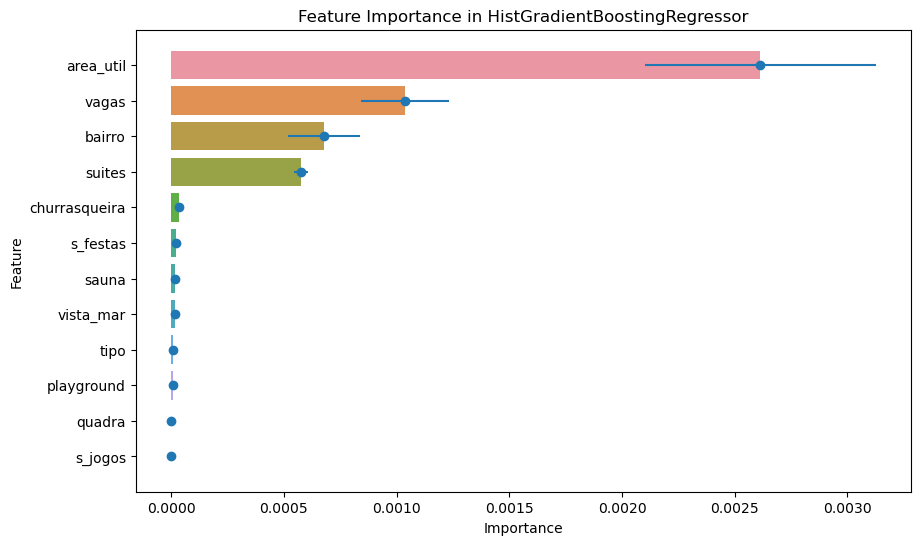

[]


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

def plot_feature_importance(model, X, y, feature_names):
    # Define metodo de calcular importancias
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

    # Calcula as importancias e suas incertezas
    feature_importance = result.importances_mean
    feature_importance_std = result.importances_std

    # Cria um df com importancias e incertezas
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance, 'Std Dev': feature_importance_std})
    unimportant_features = []
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    for i in range(len(feature_importance_df)):
        if feature_importance_df['Importance'][i] <= 0:
            unimportant_features.append(feature_importance_df['Feature'][i])

    # Plota as importancias
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.errorbar(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'],
                 xerr=feature_importance_df['Std Dev'], fmt='o')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in HistGradientBoostingRegressor')
    plt.show()
    
    print(unimportant_features)

    
feature_names = df_train.columns[:-1]
plot_feature_importance(model, X_train, y_train, feature_names)
